# Pattern Visualization

**Basic Motivation:** Show how an output of a unit is reflected/encoded in the input of the unit.

**Basic Idea:** Transform discriminative weights into generative model (just for layer input/output relation before the nonlinearity) with the covariance of the inputs and the outputs of the layer.

**Main Open Question:** How to systematically use this for many layers/deeper networks? (and do we need to account for nonlinearities/pooling then) 

## Linear classifier example

Let's take a very simplified example. It should show how we can get difficult to understand discriminative weights from common distractors / noise covariances and how to transform them to more interpretable generative "patterns".

We have a two-class problem, class Left and class Right.

Per trial we just have one datapoint from one sensor. The sensor directly shows the class.
We have 20 samples, 10 for class left and 1 for class right and sensor 1 always has low values for class left and high values for class right.


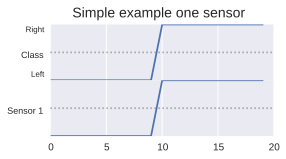

In [4]:
from braindecode.analysis.plot_util import plot_sensor_signals
import numpy as np
target = [-1] * 10 + [1] * 10
sensor_1 = [-1] * 10 + [1] * 10
sensor_2 = [0] * 20
fig = plot_sensor_signals(np.array([target, sensor_1]),
                          ('Class', 'Sensor 1',), sharey=False, figsize=(4,2))

fig.axes[0].grid(False, axis='y')
fig.axes[0].set_yticks((-0.8,0.8))

fig.axes[0].set_yticklabels(('Left','Right'), fontsize=8)
fig.suptitle('Simple example one sensor', fontsize=14, y=1.02)
None

This is all unproblematic, so let's add another sensor without any useful information and a common distractor. First, the second sensor:

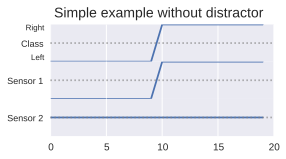

In [5]:
target = [-1] * 10 + [1] * 10
sensor_1 = [-1] * 10 + [1] * 10
sensor_2 = [0] * 20
fig = plot_sensor_signals(np.array([target, sensor_1, sensor_2]),
                          ('Class', 'Sensor 1', 'Sensor 2'), sharey=False, figsize=(4,2))

fig.axes[0].grid(False, axis='y')
fig.axes[0].set_yticks((-0.8,0.8))

fig.axes[0].set_yticklabels(('Left','Right'), fontsize=8)
fig.suptitle('Simple example without distractor', fontsize=14, y=1.02)
None

Now add the following distractor signal to both sensors:

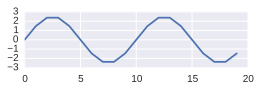

In [6]:
noise = create_sine_signal(20,freq=2, sampling_freq=20) * 2.5
pyplot.figure(figsize=(4,1))
pyplot.plot(noise)

This would be our new signals:

In [7]:
noise = create_sine_signal(20,freq=2, sampling_freq=20) * 2.5
noised_sensor_1 = sensor_1 + noise
noised_sensor_2 = sensor_2 + noise

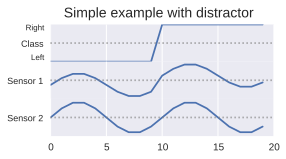

In [8]:
fig = plot_sensor_signals(np.array([target, noised_sensor_1, noised_sensor_2]), 
                          ('Class', 'Sensor 1', 'Sensor 2'), 
                          sharey=False,
                          figsize=(4,2))
fig.axes[0].grid(False, axis='y')
fig.axes[0].set_yticks((-0.8,0.8))

fig.axes[0].set_yticklabels(('Left','Right'), fontsize=8)

fig.suptitle('Simple example with distractor', fontsize=14, y=1.02)
None

If we now train a linear classifier, we get these weights:

In [9]:
#from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA

In [11]:
X = np.array([noised_sensor_1, noised_sensor_2]).T
clf = LDA()
clf.fit(X, target)

LDA(n_components=None, priors=None)

In [12]:
clf.coef_

array([[ 0.26832816],
       [-0.26832816]])

So now we get a negative weight for the second sensor, despite the fact it has only noise on it. This is because it subtracting sensor 2 from sensor 1 cancels out the common noise. So the weights itself are now misleading and do not tell us how the target class is encoded in the input.

We can "undo" this, i.e. transform to a generative model, by multiplying with the covariance matrix:

In [13]:
np.dot(np.cov(noised_sensor_1, noised_sensor_2), clf.coef_)

array([[ 0.28245069],
       [ 0.        ]])

Then indeed we get the proper encoding: The class is only encoded in the first sensor, and high values indicate the positive (Right) class.

## Formulas

I try to follow http://www.sciencedirect.com/science/article/pii/S1053811913010914#s0020.

In our linear classifier, we can also see the targets/classes as "sources" of our data. The learned weights W should then satify the following:

$$weights \cdot data = estimated \ sources$$
$$W^{\top}x(n) = \hat{s}(n)$$

where $\hat{s}(n)$ are the outputs of the classifier, the "estimated sources".


We want to see how the inputs are encoded, so we instead want:

$$patterns \cdot sources + noise = data$$
$$A \cdot s(n) + \epsilon(n) = x(n)$$


To transform from weights to patterns, we have to do:

$$patterns = covariance(weights) \cdot weights \cdot inverse(covariance(estimated \ sources))$$
$$A = \Sigma_wW\Sigma_{\hat{s}}^{-1}$$

(proof see http://www.sciencedirect.com/science/article/pii/S1053811913010914#s0210)
In case of a linear classifier the sources should have no covariances, i.e. the identity matrix as a covariance matrix.
Then it simplifies to $A = \Sigma_wW$, which is what we did in the example.


## Adapting to layers of a neural network 

### Final/Softmax Layer

For the final softmax layer, we can just use the technique as is, multiplying the covariance. We then get the encoding of a class in the inputs of the softmax layer.

## Convolutional layers

### Raw Net

For the raw net, we use the technique without many hacks I think :) The outputs of a layer are the "reconstructed sources".

We first combine the weights of the first two layers into one weight tensor, #units x #sensors x #kerneltime, e.g. 40 x 45 x 15 (it is possible since there is no nonlinearity between the first two layers).

Now we flatten the weight tensor into a matrix #units x (#sensors * #kerneltime).

Now we need the covariance matrix for the inputs. So we need the covariances between all sensor x sampletime combinations where sampletime can range between 0 and kerneltimelength - 1, e.g. 14.  When we have these covariances, 
we can multiply the covariance with the flattened weight tensor again, unfold back to get #units x #sensors x #kerneltime patterns.

To compute the covariances, we transform our  #sensors x #samples inputs into (#sensors * 15) x #samples inputs, so we construct #kerneltime virtual new sensors that look up to #kerneltime samples ahead (in other words, have the same signal, timeshifted by up to 14 samples/timesteps).


Limitations/Problems:

* probably I should also multiply with the inverse of the covariance of the outputs (giving a #unitx#unit matrix) since they now will have covariances. Should be straightforward though, no real reason I didn't do that before.
* high frequency maybe not recovered? Since low frequencies have larger amplitudes than higher frequencies, there sould always be large covariances between neighbouring timesamples. This might "smooth away" high frequency patterns.. not sure though...


## Example

This is an example from the master thesis, where I show a unit which is indicative for the right hand class (discriminates specially between right and left).

### Weights itself

In [14]:
bhno_model = serial.load(
    'data/models/pylearn/debug/raw-square/car/30-kernel-shape/early-stop/2.pkl').model

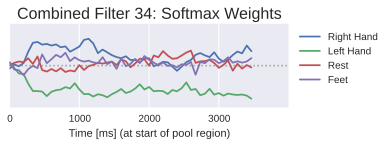

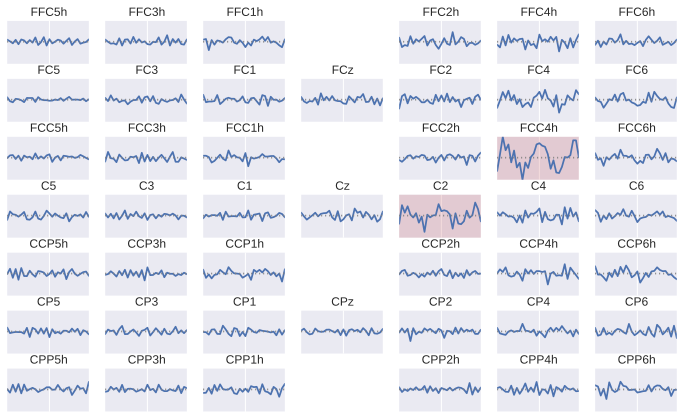

In [15]:
from braindecode.analysis.plot_util import plot_head_signals_tight
from braindecode.datasets.sensor_positions import get_C_sensors_sorted
temporal_weights = bhno_model.get_weights_topo()[:,::-1,::-1,:]
spat_filt_weights = bhno_model.layers[1].get_weights_topo()[:,::-1,::-1,:]

combined_weights = np.tensordot(spat_filt_weights, temporal_weights, axes=(3,0))

combined_weights = combined_weights.squeeze()
soft_weights = bhno_model.layers[-1].get_weights_topo().squeeze()
def highlight_chans(fig, chan_names, color=None, alpha=0.2, xstart=0, xstop=29):
    if color is None:
        color = seaborn.color_palette()[2]
    all_chan_names = np.array(get_C_sensors_sorted())
    highlight_chan_inds = [np.nonzero(all_chan_names == c)[0][0] for c in chan_names]
    for i_chan in highlight_chan_inds:
        fig.axes[i_chan].axvspan(xstart, xstop, color=color, alpha=alpha, lw=0)
        
def argsort_by_class(soft_weights, class_1, class_2, start_time_bin=None, end_time_bin=None):
    
    wanted_vs_other = soft_weights[class_1] - soft_weights[class_2]
    sorted_diffs = np.argsort(np.mean(wanted_vs_other[start_time_bin:end_time_bin], axis=0))
    return sorted_diffs

sorted_diffs = argsort_by_class(soft_weights, 0, 1)

right_best = sorted_diffs[[-1,-2]]
left_best = sorted_diffs[[0,1]]

class_names = ('Right Hand', 'Left Hand', 'Rest', 'Feet')
for i_filt in right_best[0:1]:
    fig = plot_sensor_signals(soft_weights[:,:,i_filt:i_filt+1].T, 
                        [''], 
                        figsize=(5,1.5))
    fig.axes[0].set_title("Combined Filter " + str(i_filt + 1) + ": Softmax Weights", fontsize=16)
    fig.axes[0].legend(class_names, bbox_to_anchor=(1.35, 1.), loc='upper right')
    pyplot.xticks([0,15,30,45], [0,1000,2000,3000])
    pyplot.xlabel('Time [ms] (at start of pool region)')
    fig = plot_head_signals_tight(combined_weights[i_filt], get_C_sensors_sorted())
    pyplot.xticks([15], [])
    highlight_chans(fig,  ['FCC4h', 'C2'])

### Patterns

In [18]:
%%capture
from motor_imagery_learning.analysis.input_reconstruction import (
    create_rand_input)
from motor_imagery_learning.train_scripts.train_with_params import (create_training_object,
    create_training_object_from_file)
from motor_imagery_learning.analysis.util import (
create_activations_func)
inputs = create_rand_input(bhno_model, 3)

## have to do some transformations tog et outputs before nonlinearities and I do some tests that they are all correct
transformed_model = transform_raw_net_model(bhno_model)

act_func_new = create_activations_func(transformed_model)

act_func_old = create_activations_func(bhno_model)
act_outs = act_func_new(inputs)
act_outs_old = act_func_old(inputs)

act_outs_restricted = deepcopy(act_outs)
act_outs_restricted.pop(1) # remove activations not exsting in other model (before nonlinearity)
assert all([np.allclose(a1,a2) for a1,a2 in zip(act_outs_restricted, act_outs_old)])

In [19]:
# load set and compute covariances of outputs/activations over training set
os.sys.path.insert(0, '/home/schirrmr/motor-imagery/code/motor_imagery_learning/')
bhno_train = create_training_object_from_file(
    'data/models/pylearn/debug/raw-square/car/30-kernel-shape/early-stop/2.yaml')
bhno_train.dataset_splitter.ensure_dataset_is_loaded()
datasets = bhno_train.get_train_fitted_valid_test()
train_topo = datasets['train'].get_topological_view()
acts_out = act_func_new(train_topo)
acts_out[1].shape

patterns = transform_to_patterns(combined_weights,train_topo, acts_out)

act_3 = acts_out[3]
act_3_soft_weight_shape = act_3.transpose(0,2,3,1)
assert np.array_equal(act_3_soft_weight_shape.squeeze().shape[1:], soft_weights.shape[1:]) 
act_3_for_covar = act_3_soft_weight_shape.reshape(act_3_soft_weight_shape.shape[0], -1).T
features_covar = np.cov(act_3_for_covar)

soft_weights_for_pattern = soft_weights.reshape(soft_weights.shape[0],-1)
assert soft_weights_for_pattern.shape[0] == soft_weights.shape[0]
assert soft_weights_for_pattern.shape[1] == np.prod(soft_weights.shape[1:])
soft_weights_pattern = np.dot(features_covar , soft_weights_for_pattern.T)
assert soft_weights_pattern.shape[1] == soft_weights.shape[0]
assert soft_weights_pattern.shape[0] == np.prod(soft_weights.shape[1:])
# have to transpose to again have class dimension as first dimension
soft_weights_pattern = soft_weights_pattern.T.reshape(soft_weights.shape)
assert soft_weights_pattern.shape == soft_weights.shape

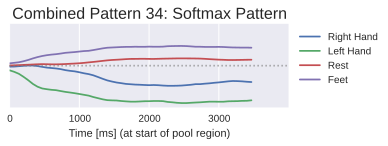

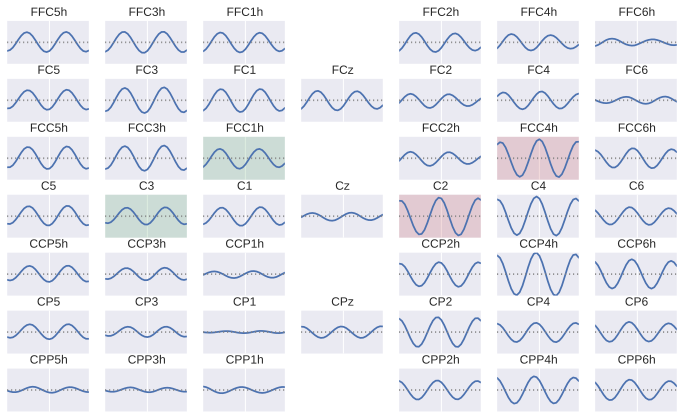

In [20]:
for i_filt in right_best[0:1]:
    fig = plot_sensor_signals(soft_weights_pattern[:,:,i_filt:i_filt+1].T, 
                        [''], 
                        figsize=(5,1.5))
    fig.axes[0].set_title("Combined Pattern " + str(i_filt + 1) + ": Softmax Pattern", fontsize=16)
    fig.axes[0].legend(class_names, bbox_to_anchor=(1.35, 1.), loc='upper right')
    pyplot.xticks([0,15,30,45], [0,1000,2000,3000])
    pyplot.xlabel('Time [ms] (at start of pool region)')
    fig = plot_head_signals_tight(patterns[i_filt], get_C_sensors_sorted())
    pyplot.xticks([15], [])
    
    highlight_chans(fig,  ['FCC4h', 'C2'])
    highlight_chans(fig,  ['FCC1h', 'C3'], color=seaborn.color_palette()[1])

We see the pattern gives us quite different information, for example it shows that a high output for this unit actually encodes rest/feet more strongly than right. Still  the discriminative weights here might discriminate for the right class, the simplest example would be if all activations of all units are always higher for the rest than for the right hand class (which is not even unrealistic in our case).

Note, I did not use covariance of the outputs here as I should have...

## Filterbank Net

For the FB Net, we can again do it similarly, I think I did the covariance calculation a bit incorrect and unnecessarily complicated in the master thesis.

We have #sensors x #time x #frequencyband inputs and  #units x #sensors weighs. So the time and frequency band dimension remain with the same shape after the linear/"convolutional" part. We can flatten the input to #sensors x (#time * #frequencyband), compute the sensor covariances and multiply again with that and with the covariances of the outputs.

However the reconstructed sensor patterns themselves are not telling us directly how a complete typical input should look like, for that we need to first compute the pattern for the softmax layer, look at the part of the pattern for a unit in the input layer and then look at the sensor pattern for that unit.



## Examples

See master thesis ;) Although there I calculated the covariances slightly didferently, I meaned covariances over all filterbands, I could just have flattened input and computed as described above I think.

## General Problems

We always just look at the linear part and ignore nonlinearities/pooling. For more layers it is not so clear to me how to systematically use this technique to get from a higher layer back down to the input (wthout manually looking at the patterns computed for each layer).


In [3]:

from pylearn2.models.mlp import ConvElemwise, IdentityConvNonlinearity
from motor_imagery_learning.mypylearn2.nonlinearities import (
    NonlinearityLayer, square_nonlin)
from copy import deepcopy
from numpy.random import RandomState
def transform_raw_net_model(model):
    """Put nonlinearity as an extra layer inbetween to compute activations before nonlinearities..."""
    transformed_model = deepcopy(model)
    oldlayer = transformed_model.layers[1]
    new_layer = ConvElemwise(output_channels=oldlayer.output_channels, 
                             kernel_shape=oldlayer.kernel_shape,
                             layer_name='new_layer',
                             nonlinearity=IdentityConvNonlinearity(),
                             kernel_stride=oldlayer.kernel_stride,
                             tied_b=True,
                             irange=0.01
                            )
    new_layer.mlp = lambda: None
    new_layer.mlp.rng = RandomState(92138)
    new_layer.mlp.batch_size = 2
    new_layer.set_input_space(oldlayer.get_input_space())
    new_layer.set_weights(oldlayer.get_param_values()[0])
    new_layer.set_biases(oldlayer.get_param_values()[1])
    nonlin_layer = NonlinearityLayer(layer_name='square_nonlin', 
                                 nonlinearity_func=square_nonlin)
    nonlin_layer.set_input_space(new_layer.get_output_space())
    transformed_model.layers = [transformed_model.layers[0],
                            new_layer, nonlin_layer, 
                           transformed_model.layers[2],
                           transformed_model.layers[3]]
    return transformed_model

def transform_to_patterns(combined_weights, train_topo, acts_out):
    """Transform raw net combined filters to combined patterns.
    Assumes kernel shape 30"""
    acts_out_for_cov = acts_out[1].transpose(1,0,2,3)
    acts_out_for_cov = acts_out_for_cov.reshape(acts_out_for_cov.shape[0], -1)
    acts_cov = np.cov(acts_out_for_cov)
    new_train_topo = np.empty((train_topo.shape[0], train_topo.shape[1] * 30,
                             train_topo.shape[2] - 30 + 1, 1))


    n_chans = train_topo.shape[1]
    n_samples = 30

    for i_sample in xrange(n_samples):
        end = -30+1+i_sample
        if end == 0:
            end = None
        for i_chan in xrange(n_chans):
            new_train_topo[:, i_chan*n_samples+i_sample, :] = \
                train_topo[:,i_chan,i_sample:end]

    new_train_topo_for_cov = new_train_topo.transpose(1,0,2,3)

    new_train_topo_for_cov = new_train_topo_for_cov.reshape(
        new_train_topo_for_cov.shape[0], -1)
    new_train_topo_cov = np.cov(new_train_topo_for_cov)
    combined_vectors = combined_weights.reshape(combined_weights.shape[0],-1)
    transformed_vectors = np.dot(new_train_topo_cov, combined_vectors.T).T
    transformed_vectors = np.dot(transformed_vectors.T, acts_cov).T
    patterns = transformed_vectors.reshape(*combined_weights.shape)
    return patterns


In [2]:
import theano

from pylearn2.utils import serial
import matplotlib
from matplotlib import pyplot
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
matplotlib.rcParams['figure.figsize'] = (12.0, 1.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')


from braindecode.analysis.data_generation import (
    create_sine_signal)

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled)


In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'

%load_ext autoreload
%autoreload 2